<a href="https://colab.research.google.com/github/xingchenzhao/study_deep_learning/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install d2lzh  # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6

![alt text](https://zh.d2l.ai/_images/densenet.svg)

In [0]:
import d2lzh as d2l
from mxnet import gluon, init, nd
from mxnet.gluon import nn

In [0]:
def conv_block(num_channels):
  blk = nn.Sequential()
  blk.add(nn.BatchNorm(), nn.Activation('relu'),
          nn.Conv2D(num_channels, kernel_size=3, padding=1))
  return blk

In [0]:
class DenseBlock(nn.Block):
  def __init__(self, num_convs, num_channels, **kwargs):
    super(DenseBlock, self).__init__(**kwargs)
    self.net = nn.Sequential()
    for _ in range(num_convs):
      self.net.add(conv_block(num_channels))

  def forward(self, X):
    for blk in self.net:
      Y = blk(X)
      X = nd.concat(X, Y, dim=1)
    return X

In [5]:
blk = DenseBlock(2, 10)
blk.initialize()
X = nd.random.uniform(shape=(4, 3, 8, 8))
Y = blk(X)
Y.shape

(4, 23, 8, 8)

In [0]:
def transition_block(num_channels):
  blk = nn.Sequential()
  blk.add(nn.BatchNorm(), nn.Activation('relu'),
          nn.Conv2D(num_channels, kernel_size=1),
          nn.AvgPool2D(pool_size=2, strides=2))
  return blk

In [7]:
blk = transition_block(10)
blk.initialize()
blk(Y).shape

(4, 10, 4, 4)

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In [0]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [6, 12, 24, 16]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
  net.add(DenseBlock(num_convs, growth_rate))
  num_channels += num_convs*growth_rate

  if i != len(num_convs_in_dense_blocks) - 1:
    num_channels //= 2
    net.add(transition_block(num_channels))

In [0]:
net.add(nn.BatchNorm(), nn.Activation('relu'), nn.GlobalAvgPool2D(), nn.Dense(10))

In [11]:
lr, num_epochs, batch_size, ctx = 0.1, 20, 256, d2l.try_gpu()
net.initialize(ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':lr})
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 0.4875, train acc 0.822, test acc 0.876, time 85.9 sec
epoch 2, loss 0.2797, train acc 0.895, test acc 0.874, time 72.1 sec
epoch 3, loss 0.2256, train acc 0.916, test acc 0.919, time 72.1 sec
epoch 4, loss 0.1965, train acc 0.928, test acc 0.922, time 72.0 sec
epoch 5, loss 0.1716, train acc 0.937, test acc 0.920, time 71.9 sec
epoch 6, loss 0.1516, train acc 0.945, test acc 0.928, time 72.0 sec
epoch 7, loss 0.1310, train acc 0.952, test acc 0.906, time 72.0 sec
epoch 8, loss 0.1151, train acc 0.958, test acc 0.927, time 72.2 sec
epoch 9, loss 0.1018, train acc 0.963, test acc 0.923, time 72.0 sec
epoch 10, loss 0.0878, train acc 0.968, test acc 0.915, time 72.0 sec
epoch 11, loss 0.0750, train acc 0.972, test acc 0.930, time 72.3 sec
epoch 12, loss 0.0598, train acc 0.979, test acc 0.915, time 72.2 sec
epoch 13, loss 0.0517, train acc 0.982, test acc 0.846, time 72.3 sec
epoch 14, loss 0.0453, train acc 0.984, test acc 0.934, time 71.9 sec
epoch 15, 

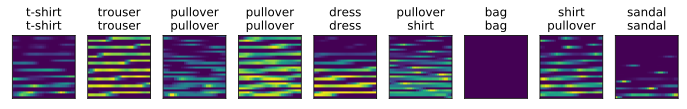

In [12]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X.as_in_context(ctx)).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])